In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

weather_df = pd.read_csv("3485342.csv")

Starting off by loading some basic libraries (referenced in the final report) necessary for operation, configuring some MatPlotLib parameters and loading the dataset.

In [2]:
weather_df.head()

,STATION,DATE,PRCP,TMAX,TMIN,WT16
0,USC00047821,1893-01-01,0.0,16.7,-1.1,NaN
1,USC00047821,1893-01-02,0.0,13.9,-2.2,NaN
2,USC00047821,1893-01-03,0.0,12.2,-1.1,NaN
3,USC00047821,1893-01-04,0.0,12.8,-2.8,NaN
4,USC00047821,1893-01-05,0.0,12.8,-2.2,NaN


In [3]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41883 entries, 0 to 41882
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  41883 non-null  object 
 1   DATE     41883 non-null  object 
 2   PRCP     41562 non-null  float64
 3   TMAX     40249 non-null  float64
 4   TMIN     40221 non-null  float64
 5   WT16     298 non-null    float64
dtypes: float64(4), object(2)
memory usage: 1.9+ MB


In [4]:
weather_df = weather_df.drop(columns=['STATION'])
weather_df = weather_df.drop(columns=['WT16'])

The dataset was specifically requested for one station, the station data is irrelevant.  
WT16 - a rain flag - has only 298 entries which is unrealistic for 41882 entries, turns out to be irrelevant as well.  
Start of with some graphs to get a sense of data:  

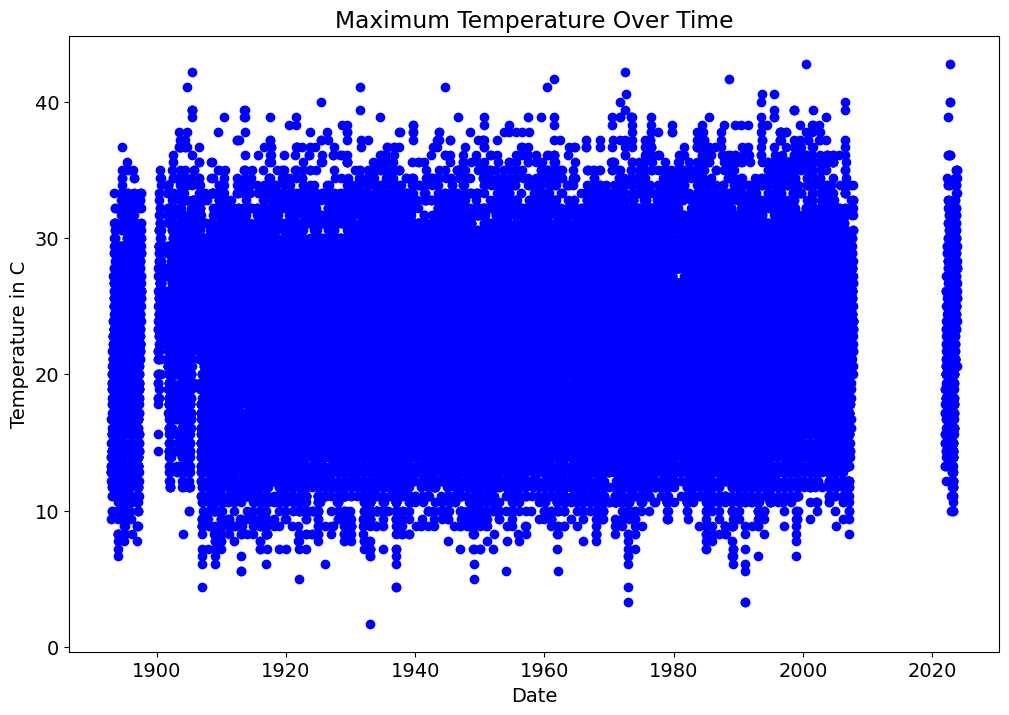

In [5]:
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

plt.title("Maximum Temperature Over Time")
plt.scatter(weather_df.DATE,weather_df.TMAX, color="blue")
plt.xlabel("Date")
plt.ylabel("Temperature in C")
plt.show()

Some gaps at the beginning and a bigger gap between ~2010-2020.   
The middle segment will be good for testing, the last bit after the gap will be used for final forecast.  

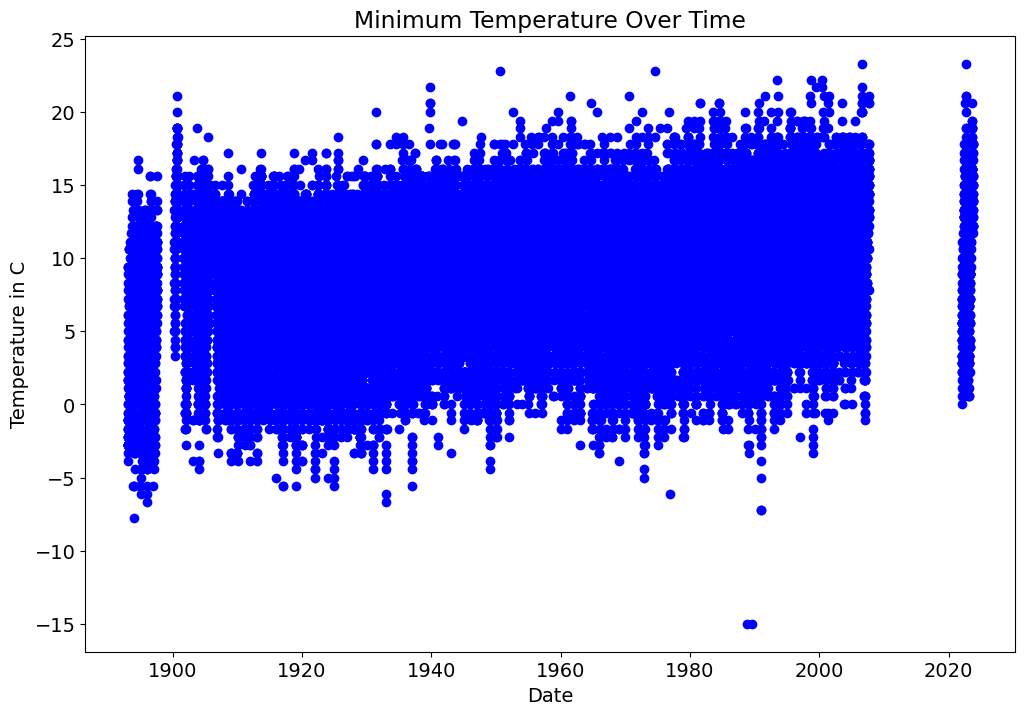

In [6]:
plt.title("Minimum Temperature Over Time")
plt.scatter(weather_df.DATE,weather_df.TMIN, color="blue")
plt.xlabel("Date")
plt.ylabel("Temperature in C")
plt.show()

Same situation here.  

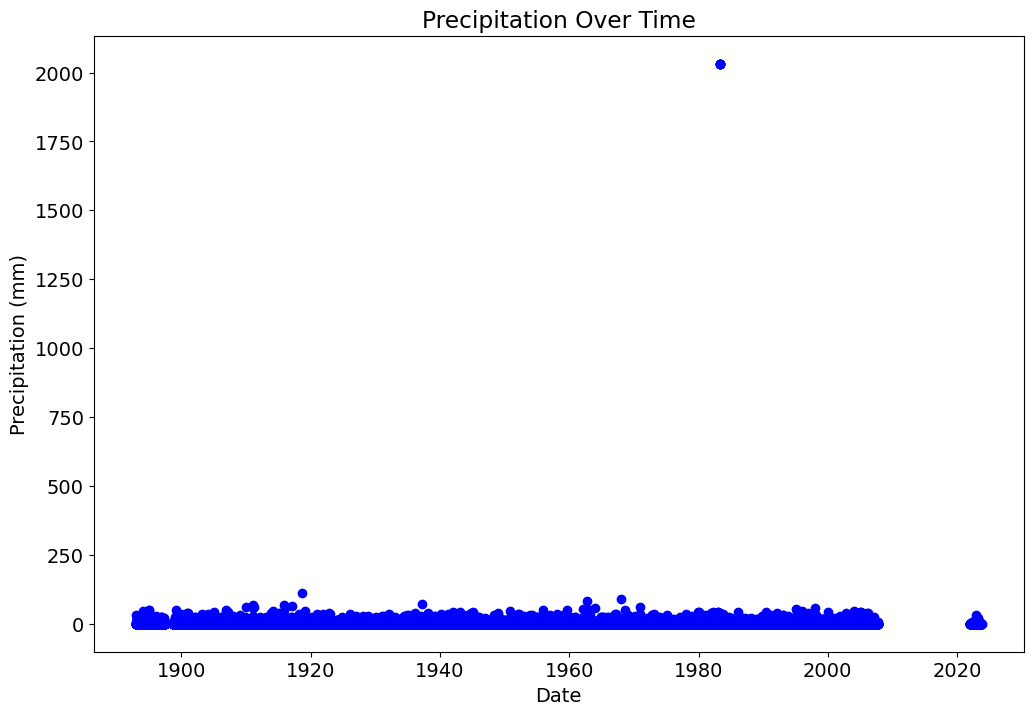

In [7]:
plt.title("Precipitation Over Time")
plt.scatter(weather_df.DATE,weather_df.PRCP, color="blue")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.show()

Dealing with gaps:

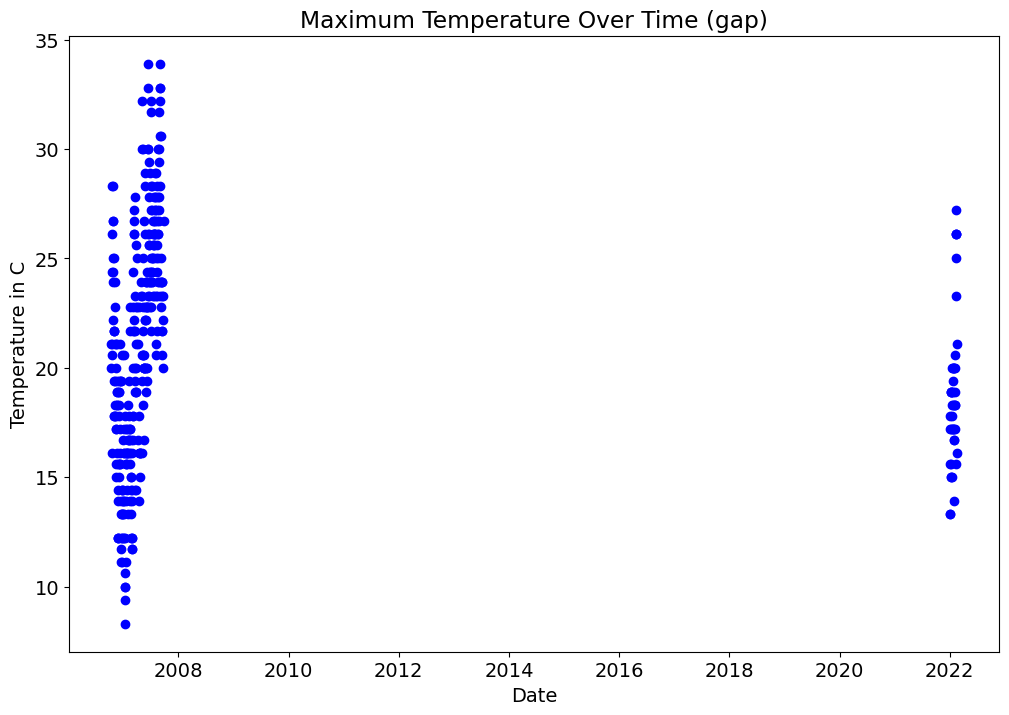

In [8]:
gap_date=weather_df.DATE.iloc[len(weather_df)-1000:len(weather_df)-600]
gap_tmax=weather_df.TMAX.iloc[len(weather_df)-1000:len(weather_df)-600]
plt.title("Maximum Temperature Over Time (gap)")
plt.scatter(gap_date,gap_tmax, color="blue")
plt.xlabel("Date")
plt.ylabel("Temperature in C")
plt.show()

During my searches for exact location (basically binary search by hand), I found that the gap lies between 2008 and 2022.  
Relevant entries for prediction that start from January 1st 2022 are bottom 645 entries (almost 2 years).
They will be used for the final model.

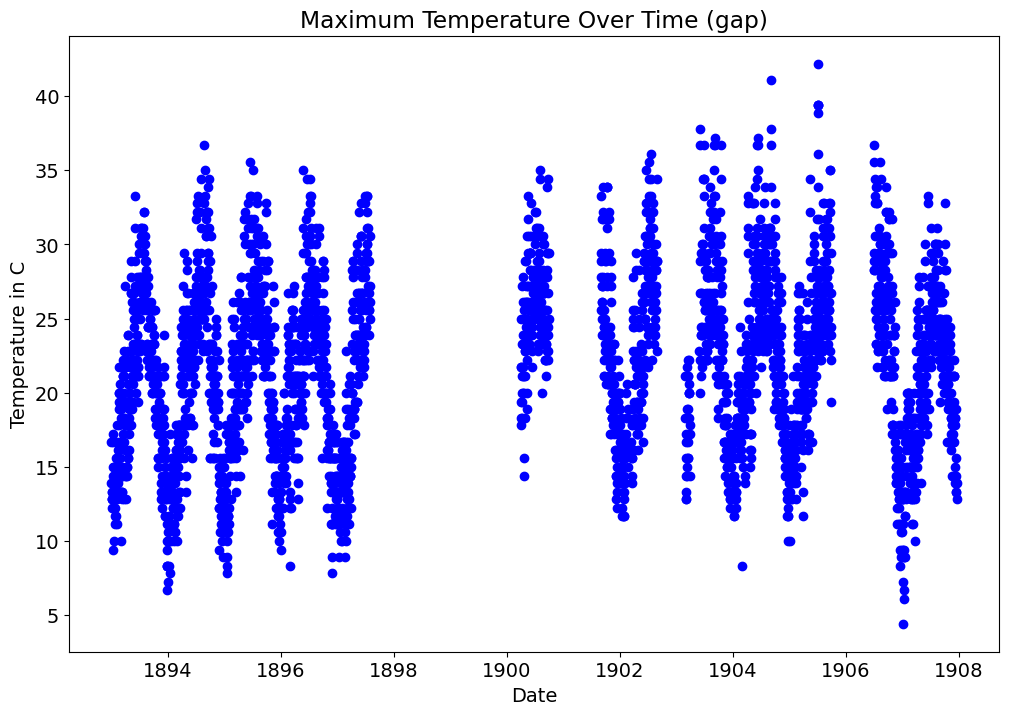

In [9]:
gap2_date=weather_df.DATE.head(5000)
gap2_tmax=weather_df.TMAX.head(5000)
plt.title("Maximum Temperature Over Time (gap)")
plt.scatter(gap2_date,gap2_tmax, color="blue")
plt.xlabel("Date")
plt.ylabel("Temperature in C")
plt.show()

Another couple of gaps are at the start.  
I will just cut off the first 5000 entries to save time, since it leaves me with plenty of data still.  

In [10]:
tmax_mask = weather_df['PRCP'].isna()
weather_df = weather_df.loc[tmax_mask == False]

tmax_mask = weather_df['TMAX'].isna()
weather_df = weather_df.loc[tmax_mask == False]

tmin_mask = weather_df['TMIN'].isna()
weather_df = weather_df.loc[tmin_mask == False]

Removing NaN values.

In [11]:
weather_df_mid=weather_df.iloc[5000:len(weather_df)-646]
weather_df_last=weather_df.tail(645)

Splitting dataset into a clean middle dataset for testing my hypotheses and the latest data for final forecast of unseen data.  
Taking a look at the results:  

In [12]:
print(weather_df_mid.head())
print(weather_df_mid.tail())
print("Length: ",len(weather_df_mid))

           DATE  PRCP  TMAX  TMIN
6599 1912-05-07   0.3  23.3   9.4
6600 1912-05-08   0.0  20.6   8.9
6601 1912-05-09   0.0  19.4  11.1
6602 1912-05-10   0.0  20.6   9.4
6603 1912-05-11   0.0  21.7   7.2
            DATE  PRCP  TMAX  TMIN
41222 2007-09-17   0.0  23.3  14.4
41223 2007-09-18   0.0  23.3  13.9
41224 2007-09-19   0.0  20.0  12.2
41225 2007-09-20   0.0  22.2  10.6
41235 2007-09-30   0.0  26.7   7.8
Length:  34313


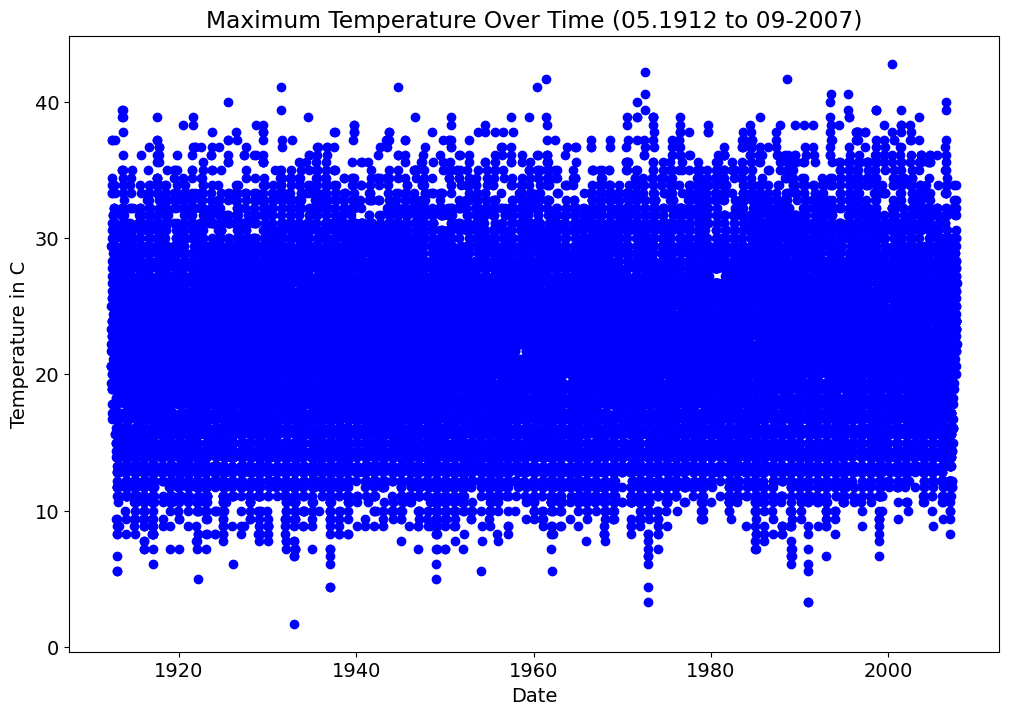

In [13]:
plt.title("Maximum Temperature Over Time (05.1912 to 09-2007)")
plt.scatter(weather_df_mid.DATE,weather_df_mid.TMAX, color="blue")
plt.xlabel("Date")
plt.ylabel("Temperature in C")
plt.show()

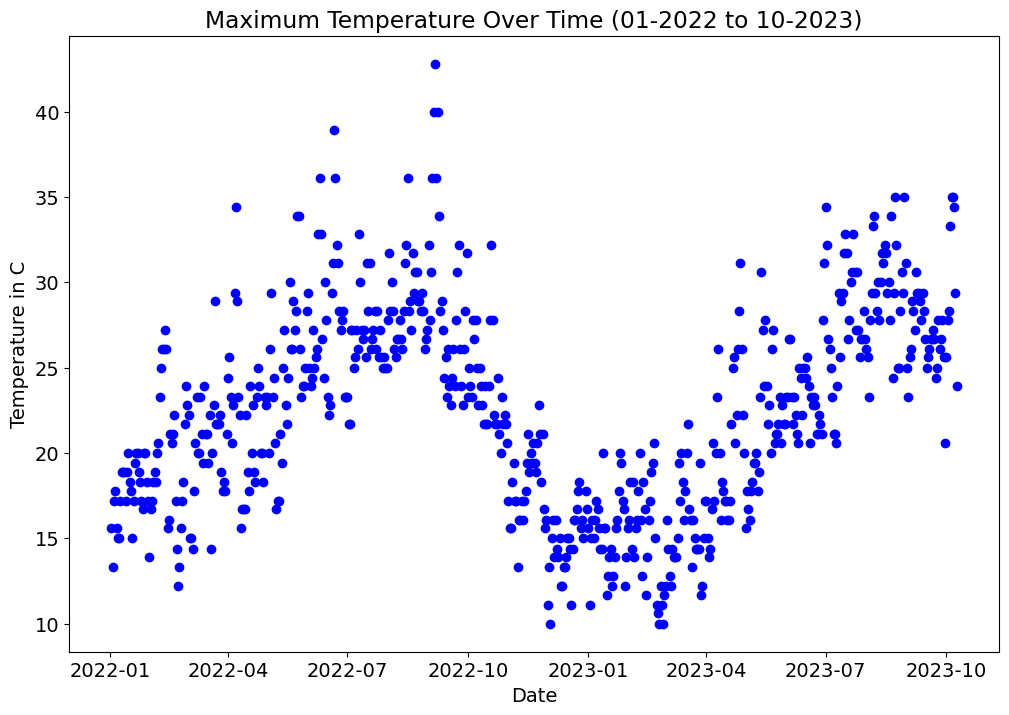

In [14]:
plt.title("Maximum Temperature Over Time (01-2022 to 10-2023)")
plt.scatter(weather_df_last.DATE,weather_df_last.TMAX, color="blue")
plt.xlabel("Date")
plt.ylabel("Temperature in C")
plt.show()

From here, the model selection process starts  
All the tests will follow predetermined guidelines:  
Due to the nature of the dataset after the preprocessing, only Time Series will be considered
TMAX is very similar to TMIN, so only TMAX will be tested for both to save time  
The size of initial train+test sets will be ~3000 (40000 is too much for most models)  
The size might be adjusted if results suggest that it might help the model  
Bare minimum of hyperparameter adjustment  
Train and test splits will be have an 80/20 proportion and the data will not be shuffled  
Graphs will be used for visual assesment of the performance  
Separate Mean Squared Error and R2 scores will be generated for each part (train/test/whole)
  
  
Models considered:  
Linear Regression   
Random Forest (Random Forest Regressor variation)  
SVM (Support Vector Regressor variation)  
KNN (K-Neighbor Regressor variation)   

In [15]:
#saving as numpy array for model performance optimization purposes
tmax_X_mid=np.asarray(weather_df_mid.DATE.tail(3000).astype('string')) 

#transfer to string because DataFrame datetime conflicts with np datetime
tmax_y_mid=np.asarray(weather_df_mid.TMAX.tail(3000))
prcp_y_mid=np.asarray(weather_df_mid.PRCP.tail(3000))

#transformation to numpy datetime
for i in range(len(tmax_X_mid)):
    tmax_X_mid[i]=np.datetime64(tmax_X_mid[i])

#transformation into one dimensional array as required for 1 feature models
tmax_X_mid=tmax_X_mid.reshape(-1, 1)


#creating X and y splits (feature/tartget) that will be used for initial testing
tmax_X_train, tmax_X_test, tmax_y_train, tmax_y_test=\
train_test_split(tmax_X_mid, tmax_y_mid, test_size= 0.2, shuffle=False)

prcp_X_train, prcp_X_test, prcp_y_train, prcp_y_test=\
train_test_split(tmax_X_mid, prcp_y_mid, test_size= 0.2, shuffle=False)

In [16]:
#importing the model
from sklearn import linear_model

#initializing the models
lin_tmax = linear_model.LinearRegression()
lin_prcp = linear_model.LinearRegression()

#train the models using the training sets
lin_tmax.fit(tmax_X_train, tmax_y_train)
lin_prcp.fit(prcp_X_train, prcp_y_train)

#make predictions using the entire X
tmax_y_pred = lin_tmax.predict(tmax_X_mid)
prcp_y_pred = lin_prcp.predict(tmax_X_mid)

# The coefficient of determination: 1 is perfect prediction
print("TMAX Coefficient of determination (entire set): %.2f" % r2_score(tmax_y_mid, tmax_y_pred))
print("TMAX Coefficient of determination (train set): %.2f" % r2_score(tmax_y_mid[:600], tmax_y_pred[:600]))
print("TMAX Coefficient of determination (test set): %.2f" % r2_score(tmax_y_mid[-600:], tmax_y_pred[-600:]))

print("--------------------------------------------------------------------------")

# The coefficient of determination: 1 is perfect prediction
print("PRCP Coefficient of determination (entire set): %.2f" % r2_score(prcp_y_mid, prcp_y_pred))
print("PRCP Coefficient of determination (train set): %.2f" % r2_score(prcp_y_mid[:600], prcp_y_pred[:600]))
print("PRCP Coefficient of determination (test set): %.2f" % r2_score(prcp_y_mid[-600:], prcp_y_pred[-600:]))

print("--------------------------------------------------------------------------")

TMAX Coefficient of determination (entire set): -0.00
TMAX Coefficient of determination (train set): 0.01
TMAX Coefficient of determination (test set): -0.02
--------------------------------------------------------------------------
PRCP Coefficient of determination (entire set): -0.00
PRCP Coefficient of determination (train set): -0.00
PRCP Coefficient of determination (test set): -0.00
--------------------------------------------------------------------------


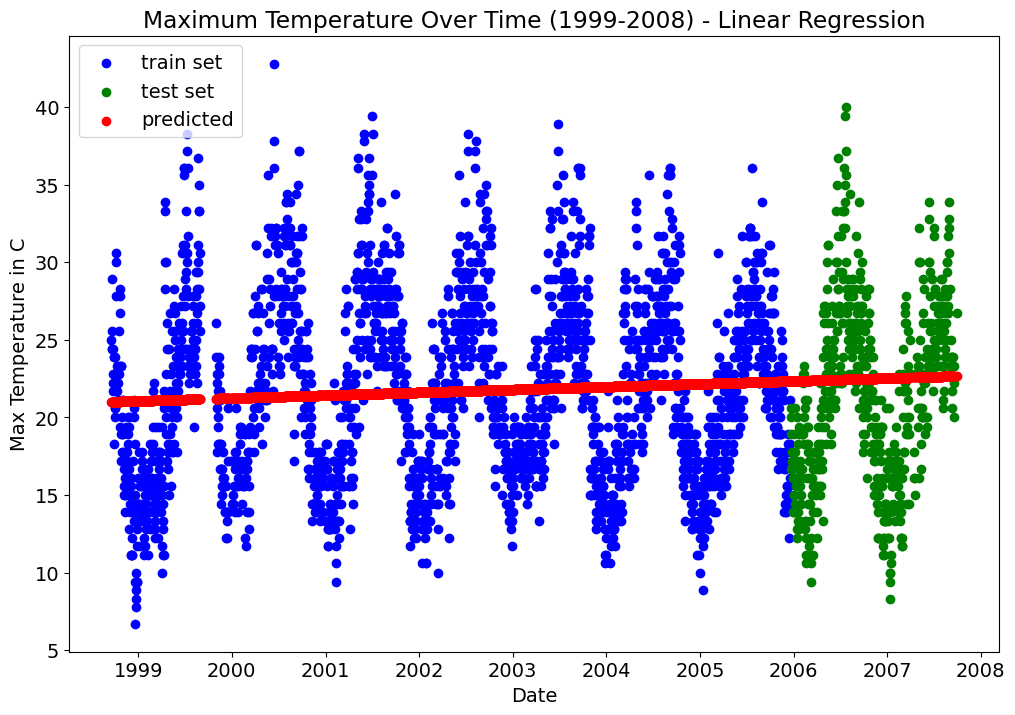

In [17]:
plt.title("Maximum Temperature Over Time (1999-2008) - Linear Regression")
plt.scatter(tmax_X_train, tmax_y_train, color="blue")
plt.scatter(tmax_X_test, tmax_y_test, color="green")
plt.scatter(tmax_X_mid, tmax_y_pred, color="red")
plt.xlabel("Date")
plt.ylabel("Max Temperature in C")
plt.legend(['train set','test set','predicted'])

plt.show()

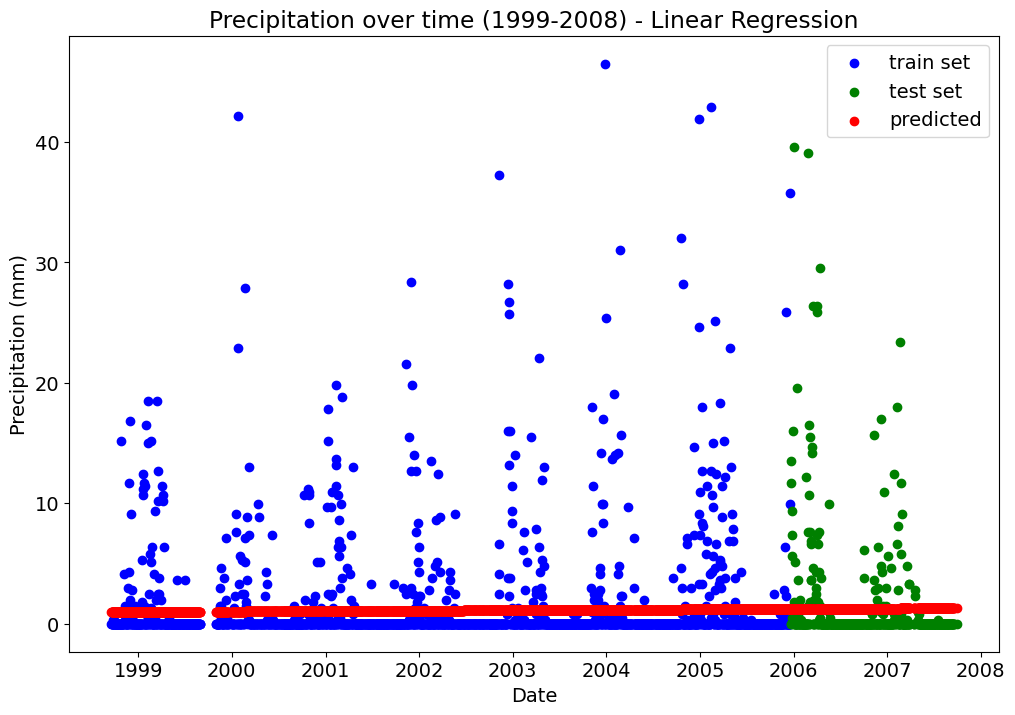

In [18]:
plt.title("Precipitation over time (1999-2008) - Linear Regression")
plt.scatter(prcp_X_train, prcp_y_train, color="blue")
plt.scatter(prcp_X_test, prcp_y_test, color="green")
plt.scatter(tmax_X_mid, prcp_y_pred, color="red")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.legend(['train set','test set','predicted'])

plt.show()

Due to the model being 1 feature (Time Series) model, Linear Regression is only capable of predicting a straight line.  
It definitely shows a trend, however, it is not a very good prediction. Could be good on smaller intervals where there is a linear trend.  

In [19]:
from sklearn.ensemble import RandomForestRegressor

# Initializing the model with n_estimators=100 (a default value)
rfo_tmax = RandomForestRegressor(n_estimators=100)
rfo_prcp = RandomForestRegressor(n_estimators=100)

# Train the model using the training sets
rfo_tmax.fit(tmax_X_train, tmax_y_train)
rfo_prcp.fit(prcp_X_train, prcp_y_train)

# Make predictions using the entire X
tmax_y_pred = rfo_tmax.predict(tmax_X_mid)
prcp_y_pred = rfo_prcp.predict(tmax_X_mid)


# The coefficient of determination: 1 is perfect prediction
print("TMAX Coefficient of determination (entire set): %.2f" % r2_score(tmax_y_mid, tmax_y_pred))
print("TMAX Coefficient of determination (train set): %.2f" % r2_score(tmax_y_mid[:600], tmax_y_pred[:600]))
print("TMAX Coefficient of determination (test set): %.2f" % r2_score(tmax_y_mid[-600:], tmax_y_pred[-600:]))

print("--------------------------------------------------------------------------")


# The coefficient of determination: 1 is perfect prediction
print("PRCP Coefficient of determination (entire set): %.2f" % r2_score(prcp_y_mid, prcp_y_pred))
print("PRCP Coefficient of determination (train set): %.2f" % r2_score(prcp_y_mid[:600], prcp_y_pred[:600]))
print("PRCP Coefficient of determination (test set): %.2f" % r2_score(prcp_y_mid[-600:], prcp_y_pred[-600:]))

print("--------------------------------------------------------------------------")

TMAX Coefficient of determination (entire set): 0.78
TMAX Coefficient of determination (train set): 0.98
TMAX Coefficient of determination (test set): -0.08
--------------------------------------------------------------------------
PRCP Coefficient of determination (entire set): 0.60
PRCP Coefficient of determination (train set): 0.86
PRCP Coefficient of determination (test set): -0.32
--------------------------------------------------------------------------


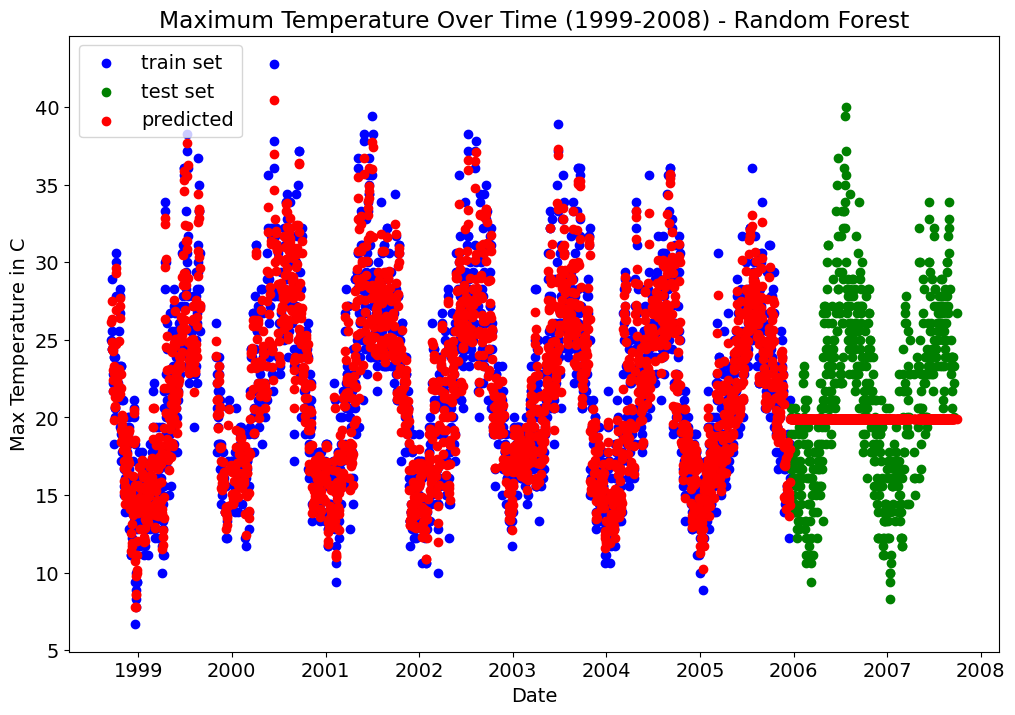

In [20]:
plt.title("Maximum Temperature Over Time (1999-2008) - Random Forest")
plt.scatter(tmax_X_train, tmax_y_train, color="blue")
plt.scatter(tmax_X_test, tmax_y_test, color="green")
plt.scatter(tmax_X_mid, tmax_y_pred, color="red")
plt.xlabel("Date")
plt.ylabel("Max Temperature in C")
plt.legend(['train set','test set','predicted'])

plt.show()

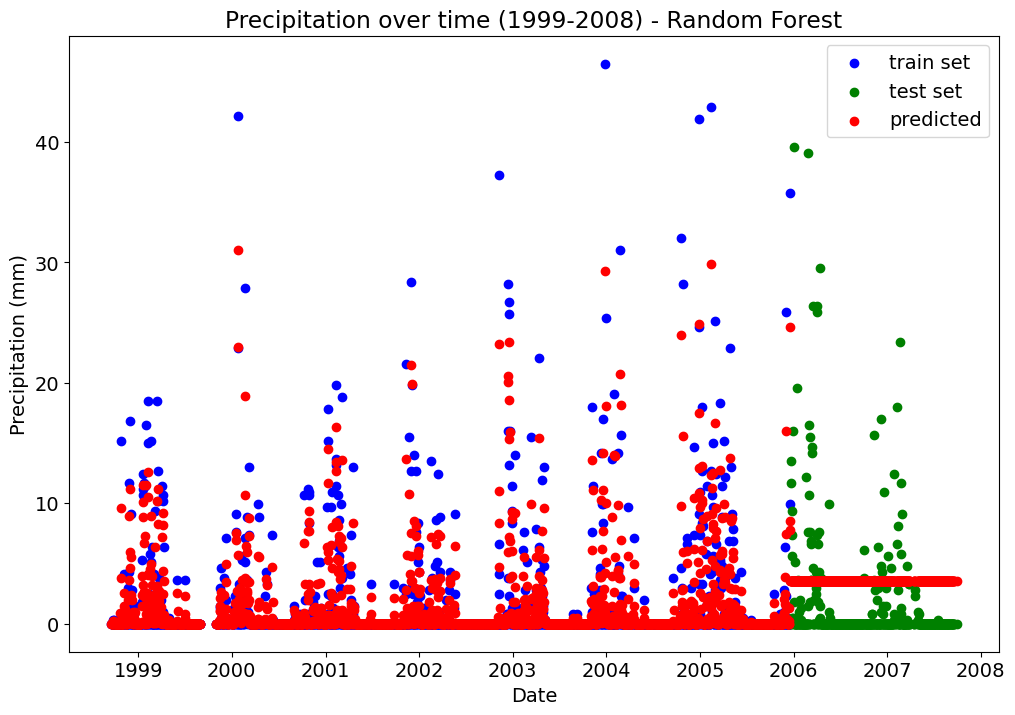

In [21]:
plt.title("Precipitation over time (1999-2008) - Random Forest")
plt.scatter(prcp_X_train, prcp_y_train, color="blue")
plt.scatter(prcp_X_test, prcp_y_test, color="green")
plt.scatter(tmax_X_mid, prcp_y_pred, color="red")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.legend(['train set','test set','predicted'])

plt.show()

Random forest seems to be limited in its predictability. It flatlines as soon as the training set ends.

In [22]:
from sklearn.svm import SVR

# Initializing the model
svr_tmax = SVR()
svr_prcp = SVR()

# Train the model using the training sets
svr_tmax.fit(tmax_X_train, tmax_y_train)
svr_prcp.fit(prcp_X_train, prcp_y_train)

# Make predictions using the entire X
tmax_y_pred = svr_tmax.predict(tmax_X_mid)
prcp_y_pred = svr_prcp.predict(tmax_X_mid)


# The coefficient of determination: 1 is perfect prediction
print("TMAX Coefficient of determination (entire set): %.2f" % r2_score(tmax_y_mid, tmax_y_pred))
print("TMAX Coefficient of determination (train set): %.2f" % r2_score(tmax_y_mid[:600], tmax_y_pred[:600]))
print("TMAX Coefficient of determination (test set): %.2f" % r2_score(tmax_y_mid[-600:], tmax_y_pred[-600:]))

print("--------------------------------------------------------------------------")


# The coefficient of determination: 1 is perfect prediction
print("PRCP Coefficient of determination (entire set): %.2f" % r2_score(prcp_y_mid, prcp_y_pred))
print("PRCP Coefficient of determination (train set): %.2f" % r2_score(prcp_y_mid[:600], prcp_y_pred[:600]))
print("PRCP Coefficient of determination (test set): %.2f" % r2_score(prcp_y_mid[-600:], prcp_y_pred[-600:]))

print("--------------------------------------------------------------------------")

TMAX Coefficient of determination (entire set): 0.02
TMAX Coefficient of determination (train set): 0.13
TMAX Coefficient of determination (test set): -0.02
--------------------------------------------------------------------------
PRCP Coefficient of determination (entire set): -0.06
PRCP Coefficient of determination (train set): -0.07
PRCP Coefficient of determination (test set): -0.06
--------------------------------------------------------------------------


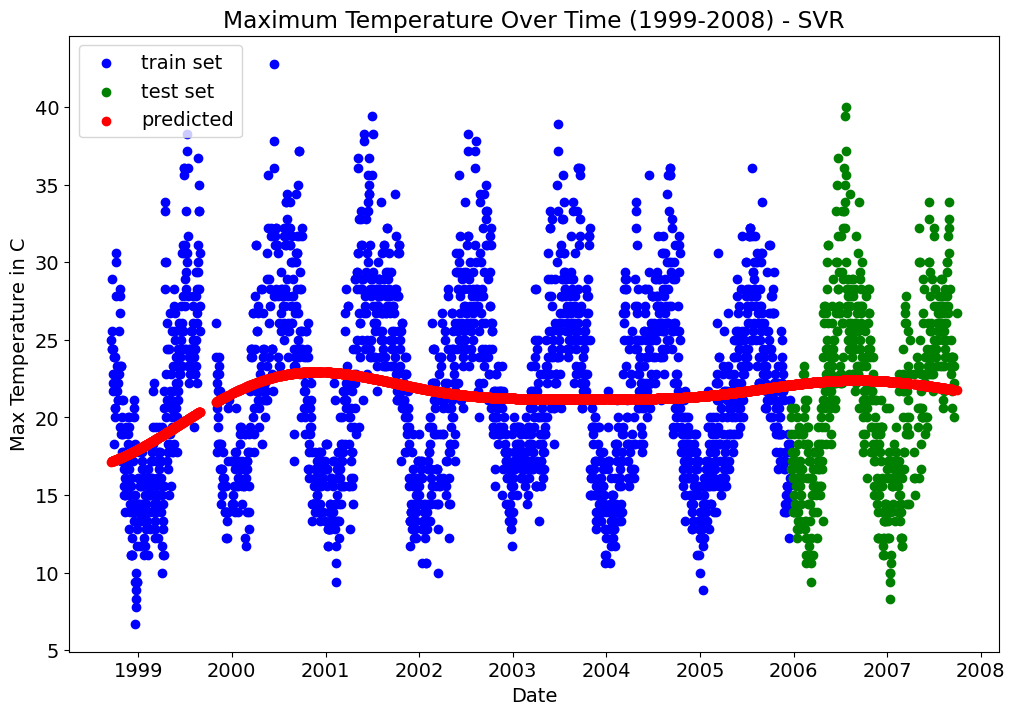

In [23]:
plt.title("Maximum Temperature Over Time (1999-2008) - SVR")
plt.scatter(tmax_X_train, tmax_y_train, color="blue")
plt.scatter(tmax_X_test, tmax_y_test, color="green")
plt.scatter(tmax_X_mid, tmax_y_pred, color="red")
plt.xlabel("Date")
plt.ylabel("Max Temperature in C")
plt.legend(['train set','test set','predicted'])

plt.show()

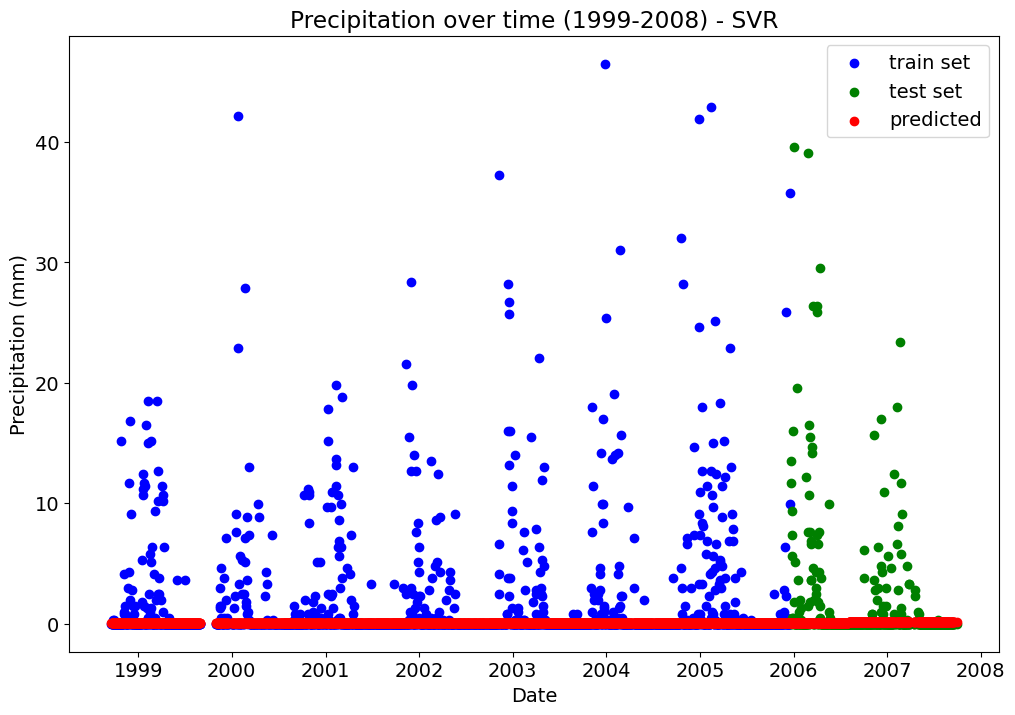

In [24]:
plt.title("Precipitation over time (1999-2008) - SVR")
plt.scatter(prcp_X_train, prcp_y_train, color="blue")
plt.scatter(prcp_X_test, prcp_y_test, color="green")
plt.scatter(tmax_X_mid, prcp_y_pred, color="red")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.legend(['train set','test set','predicted'])

plt.show()

The fit with default hyperparameters is surprisinglt terrible but it also shows tendency to have some 'movement' in the test set (not flatlining).  
Worth quick investigatiing with different hyperparameters.

In [25]:
# Initializing the model with default rbf kernel 
# but irregular values of C=10 and gamma=0.0001 (the two main rbf hyperparameters)
# The values were discovered while manually trying several different values in the initial tests
svr_tmax = SVR(kernel='rbf', C=10, gamma=0.0001)
svr_prcp = SVR(kernel='rbf', C=10, gamma=0.0001)

# Train the model using the training sets
svr_tmax.fit(tmax_X_train, tmax_y_train)
svr_prcp.fit(prcp_X_train, prcp_y_train)

# Make predictions using the entire X
tmax_y_pred = svr_tmax.predict(tmax_X_mid)
prcp_y_pred = svr_prcp.predict(tmax_X_mid)


# The coefficient of determination: 1 is perfect prediction
print("TMAX Coefficient of determination (entire set): %.2f" % r2_score(tmax_y_mid, tmax_y_pred))
print("TMAX Coefficient of determination (train set): %.2f" % r2_score(tmax_y_mid[:600], tmax_y_pred[:600]))
print("TMAX Coefficient of determination (test set): %.2f" % r2_score(tmax_y_mid[-600:], tmax_y_pred[-600:]))

print("--------------------------------------------------------------------------")


# The coefficient of determination: 1 is perfect prediction
print("PRCP Coefficient of determination (entire set): %.2f" % r2_score(prcp_y_mid, prcp_y_pred))
print("PRCP Coefficient of determination (train set): %.2f" % r2_score(prcp_y_mid[:600], prcp_y_pred[:600]))
print("PRCP Coefficient of determination (test set): %.2f" % r2_score(prcp_y_mid[-600:], prcp_y_pred[-600:]))

print("--------------------------------------------------------------------------")

TMAX Coefficient of determination (entire set): 0.55
TMAX Coefficient of determination (train set): 0.67
TMAX Coefficient of determination (test set): 0.08
--------------------------------------------------------------------------
PRCP Coefficient of determination (entire set): -0.06
PRCP Coefficient of determination (train set): -0.07
PRCP Coefficient of determination (test set): -0.06
--------------------------------------------------------------------------


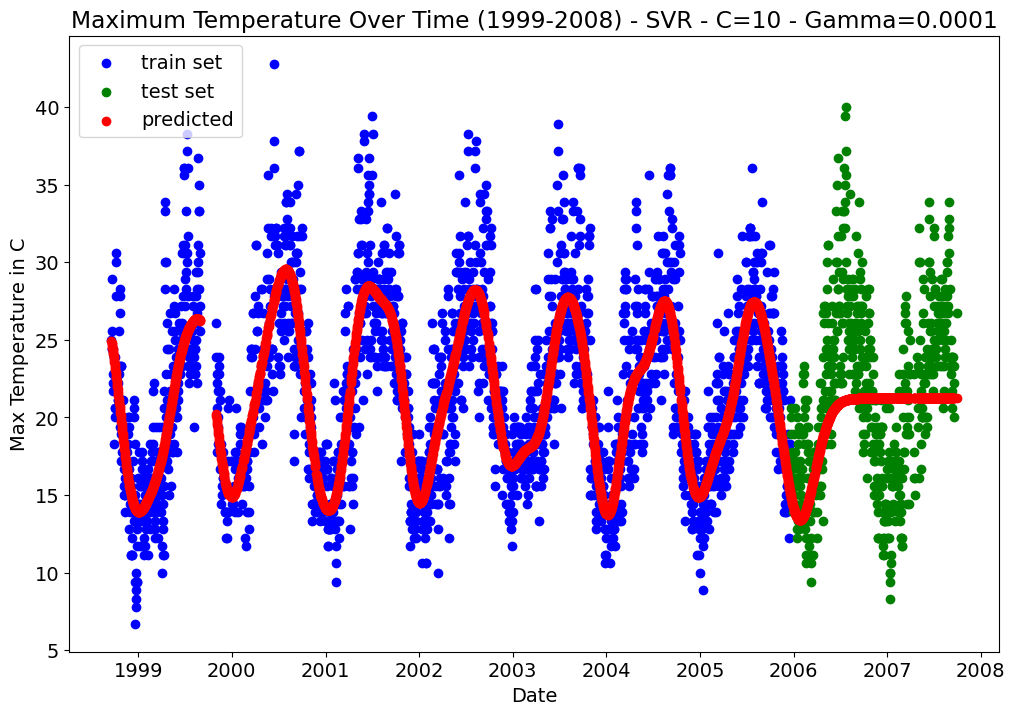

In [26]:
plt.title("Maximum Temperature Over Time (1999-2008) - SVR - C=10 - Gamma=0.0001")
plt.scatter(tmax_X_train, tmax_y_train, color="blue")
plt.scatter(tmax_X_test, tmax_y_test, color="green")
plt.scatter(tmax_X_mid, tmax_y_pred, color="red")
plt.xlabel("Date")
plt.ylabel("Max Temperature in C")
plt.legend(['train set','test set','predicted'])

plt.show()

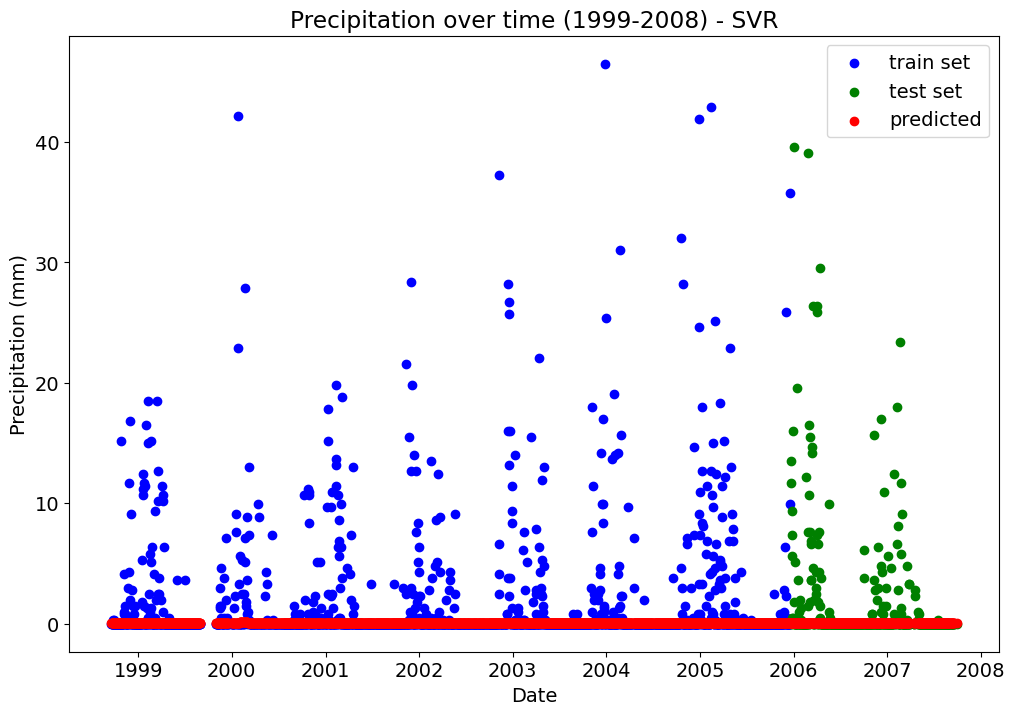

In [27]:
plt.title("Precipitation over time (1999-2008) - SVR")
plt.scatter(prcp_X_train, prcp_y_train, color="blue")
plt.scatter(prcp_X_test, prcp_y_test, color="green")
plt.scatter(tmax_X_mid, prcp_y_pred, color="red")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.legend(['train set','test set','predicted'])

plt.show()

The default values of SVR did not show a good fit but demonstrated tendency not to flatline unlike Random Forest.  
That prompted further research of hyperparameters that in the end proven to yield interesting results for TMAX.  
SVR might be capable of predicting and is worth further investigation.  
The precipitation is still unpredictable.  

In [28]:
from sklearn.neighbors import KNeighborsRegressor 
error_rate=[]
error_rate2=[]

#attempting the recommended elbow method
#code from lectures and personal assignments

for i in range(1,100):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(tmax_X_train, tmax_y_train)
    pred=knn.predict(tmax_X_test)
    error_rate.append(np.mean(pred != tmax_y_test))
    
for i in range(1,100):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(prcp_X_train, prcp_y_train)
    pred=knn.predict(prcp_X_test)
    error_rate2.append(np.mean(pred != prcp_y_test))

k needs to be 7, with obtained minimum error 0.96


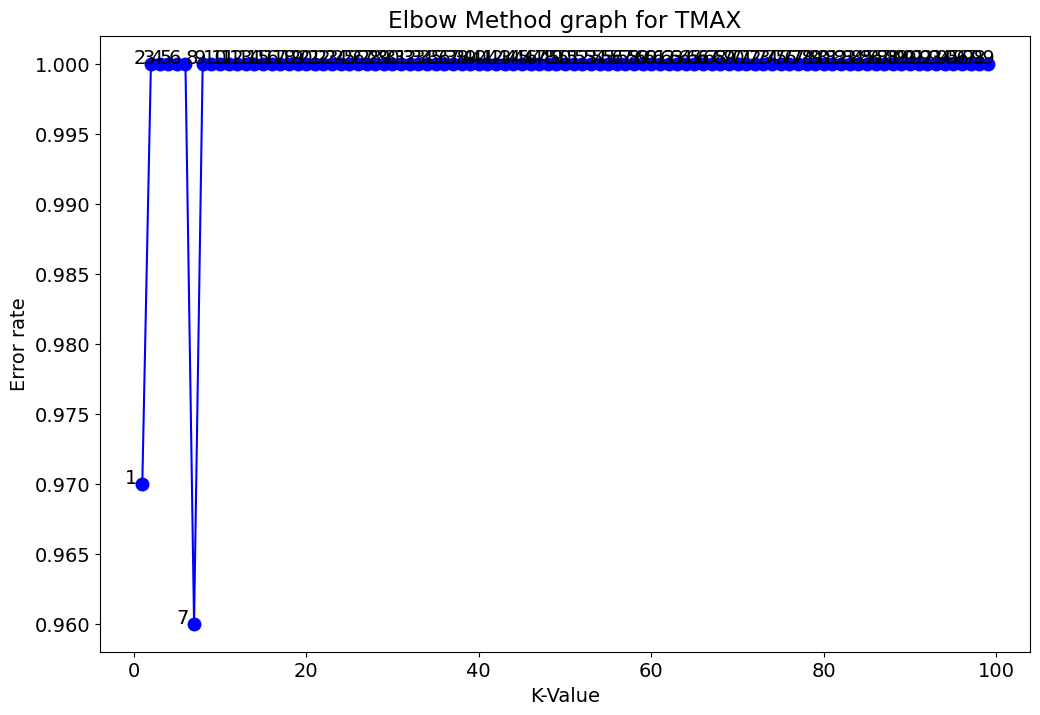

In [29]:
plt.plot(range(1,100), error_rate, marker='o',markersize=9, color="blue")
for i in range(len(error_rate)):
    plt.annotate(i+1, (i-1,error_rate[i]))
    
plt.title("Elbow Method graph for TMAX")
plt.xlabel("K-Value")
plt.ylabel("Error rate")
print('k needs to be {}, with obtained minimum error {}'.format(error_rate.index(min(error_rate))+1, min(error_rate)))

k needs to be 1, with obtained minimum error 0.17166666666666666


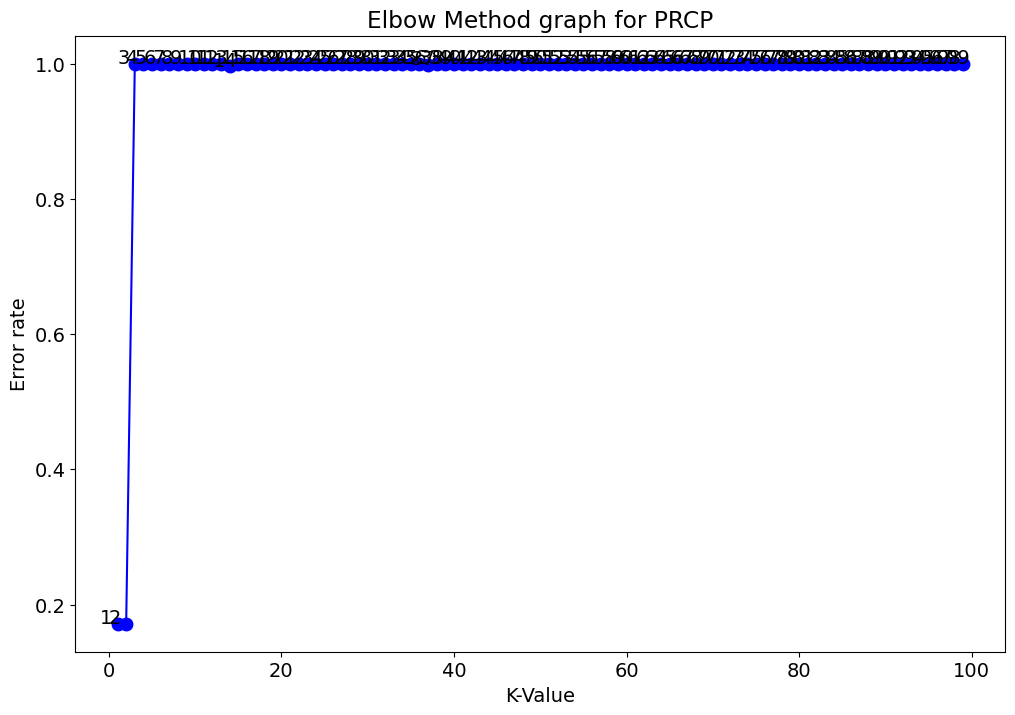

In [30]:
plt.plot(range(1,100), error_rate2, marker='o',markersize=9, color="blue")
for i in range(len(error_rate2)):
    plt.annotate(i+1, (i-1,error_rate2[i]))

plt.title("Elbow Method graph for PRCP")
plt.xlabel("K-Value")
plt.ylabel("Error rate")
print('k needs to be {}, with obtained minimum error {}'.format(error_rate2.index(min(error_rate2))+1, min(error_rate2)))

The elbow method's result is a bad omen, it looks nothing like an 'elbow' it is supposed to be  
Will use the suggested values anyway   

In [31]:
# Initilizing the models with suggested values
knn_tmax = KNeighborsRegressor(n_neighbors=7)
knn_prcp = KNeighborsRegressor(n_neighbors=2)

# Train the model using the training sets
knn_tmax.fit(tmax_X_train, tmax_y_train)
knn_prcp.fit(prcp_X_train, prcp_y_train)

# Make predictions using the entire X
tmax_y_pred = knn_tmax.predict(tmax_X_mid)
prcp_y_pred = knn_prcp.predict(tmax_X_mid)

# The mean squared error
print("TMAX Mean squared error (entire set): %.2f" % mean_squared_error(tmax_y_mid, tmax_y_pred))
print("TMAX Mean squared error (train set): %.2f" % mean_squared_error(tmax_y_mid[:600], tmax_y_pred[:600]))
print("TMAX Mean squared error (test set): %.2f " % mean_squared_error(tmax_y_mid[-600:], tmax_y_pred[-600:]))
# The coefficient of determination: 1 is perfect prediction
print("TMAX Coefficient of determination (entire set): %.2f" % r2_score(tmax_y_mid, tmax_y_pred))
print("TMAX Coefficient of determination (train set): %.2f" % r2_score(tmax_y_mid[:600], tmax_y_pred[:600]))
print("TMAX Coefficient of determination (test set): %.2f" % r2_score(tmax_y_mid[-600:], tmax_y_pred[-600:]))

print("--------------------------------------------------------------------------")


# The mean squared error
print("PRCP Mean squared error (entire set): %.2f" % mean_squared_error(prcp_y_mid, prcp_y_pred))
print("PRCP Mean squared error (train set): %.2f" % mean_squared_error(prcp_y_mid[:600], prcp_y_pred[:600]))
print("PRCP Mean squared error (test set): %.2f" % mean_squared_error(prcp_y_mid[-600:], prcp_y_pred[-600:]))

# The coefficient of determination: 1 is perfect prediction
print("PRCP Coefficient of determination (entire set): %.2f" % r2_score(prcp_y_mid, prcp_y_pred))
print("PRCP Coefficient of determination (train set): %.2f" % r2_score(prcp_y_mid[:600], prcp_y_pred[:600]))
print("PRCP Coefficient of determination (test set): %.2f" % r2_score(prcp_y_mid[-600:], prcp_y_pred[-600:]))

print("--------------------------------------------------------------------------")

TMAX Mean squared error (entire set): 16.87
TMAX Mean squared error (train set): 5.71
TMAX Mean squared error (test set): 61.95 
TMAX Coefficient of determination (entire set): 0.51
TMAX Coefficient of determination (train set): 0.86
TMAX Coefficient of determination (test set): -0.89
--------------------------------------------------------------------------
PRCP Mean squared error (entire set): 8.21
PRCP Mean squared error (train set): 4.02
PRCP Mean squared error (test set): 18.92
PRCP Coefficient of determination (entire set): 0.49
PRCP Coefficient of determination (train set): 0.67
PRCP Coefficient of determination (test set): -0.08
--------------------------------------------------------------------------


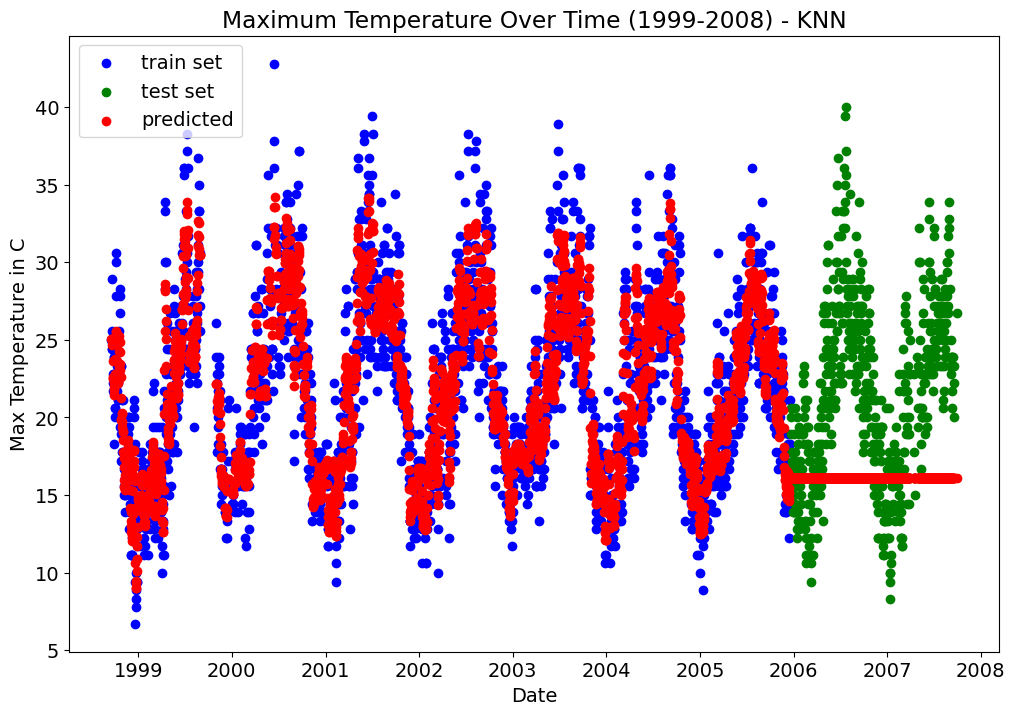

In [32]:
plt.title("Maximum Temperature Over Time (1999-2008) - KNN")
plt.scatter(tmax_X_train, tmax_y_train, color="blue")
plt.scatter(tmax_X_test, tmax_y_test, color="green")
plt.scatter(tmax_X_mid, tmax_y_pred, color="red")
plt.xlabel("Date")
plt.ylabel("Max Temperature in C")
plt.legend(['train set','test set','predicted'])

plt.show()

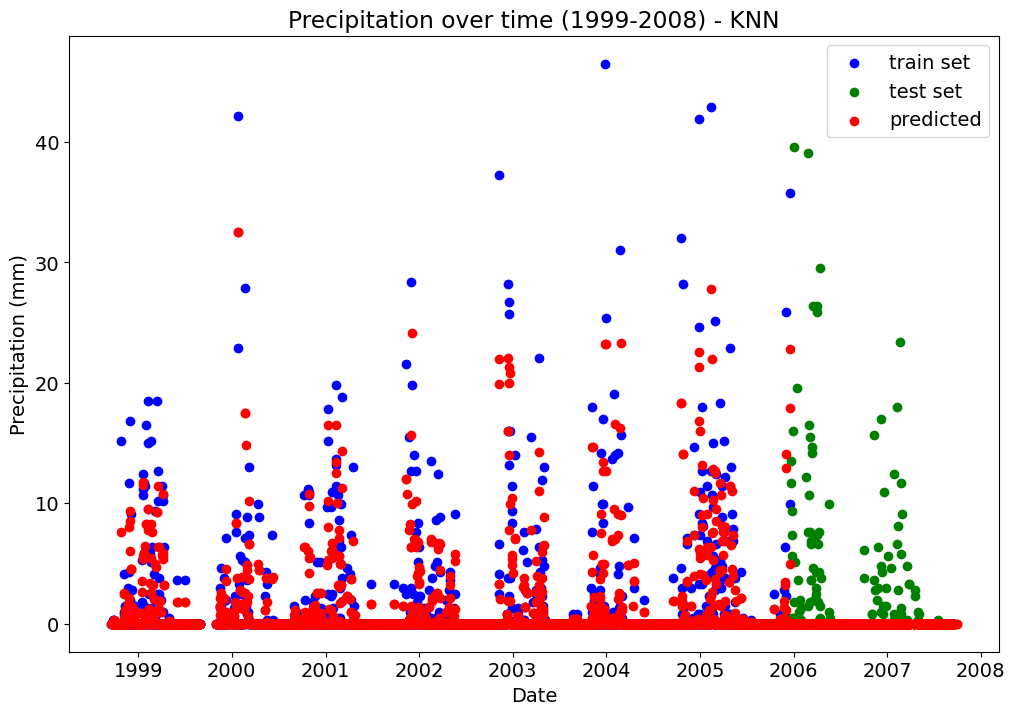

In [33]:
plt.title("Precipitation over time (1999-2008) - KNN")
plt.scatter(prcp_X_train, prcp_y_train, color="blue")
plt.scatter(prcp_X_test, prcp_y_test, color="green")
plt.scatter(tmax_X_mid, prcp_y_pred, color="red")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.legend(['train set','test set','predicted'])

plt.show()

KNN also flatlines right after the seen (training) data.

Through these quick tests it is noticeable that all the models struggle to find any trends within precipitation data.   
While some are capable to place points well enough in training set, every model fails to predict precipitation.    
Precipitation is now out of scope of the project.  
  
On the other hand, Linear Regression is capable of predicting TMAX in small measures and SVR shows potential in predicting for longer terms.  
  
   
Starting with SVR since it looks more interesting.

In [34]:
weather_df_mid=weather_df_mid.drop(columns=['PRCP'])
weather_df_last=weather_df_last.drop(columns=['PRCP'])

weather_df_mid.head()

,DATE,TMAX,TMIN
6599,1912-05-07,23.3,9.4
6600,1912-05-08,20.6,8.9
6601,1912-05-09,19.4,11.1
6602,1912-05-10,20.6,9.4
6603,1912-05-11,21.7,7.2


There are a lot of potential combinations of hyperparameters for SVR  
Picking them by hand is impractical and hard to systematize  
Instead, loops will be used   
  
Investigating SVR:  

A score above 0 determined for 0-645:                    best C: 95, best gamma= 1e-05, R2 for test=0.010658802022989078


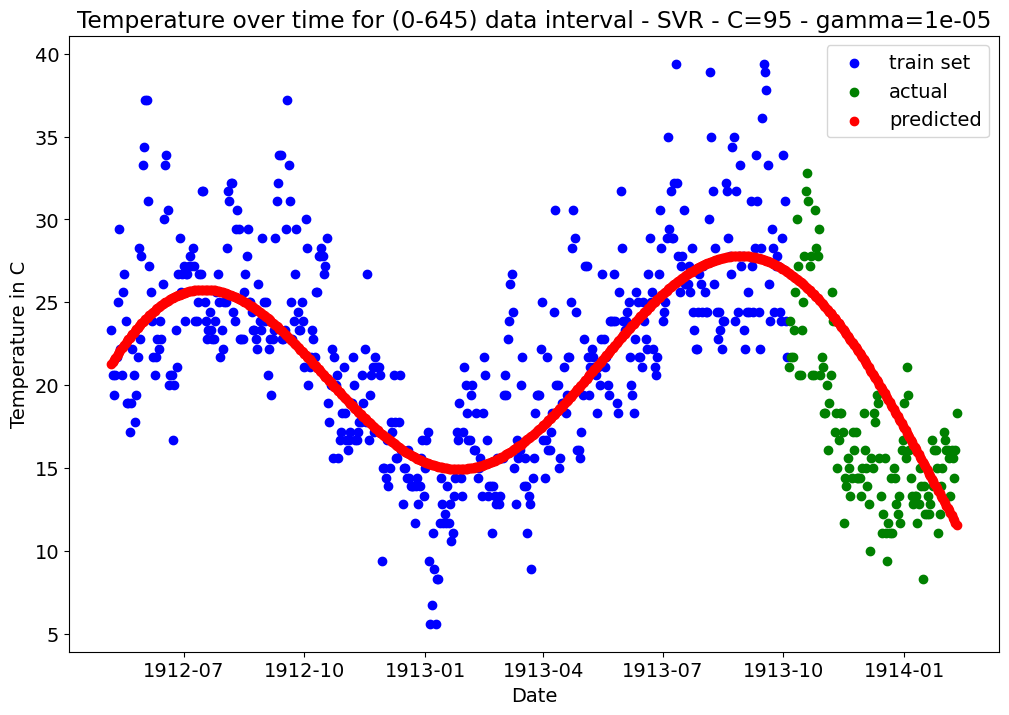

A score above 0 determined for 0-645:                    best C: 96, best gamma= 1e-05, R2 for test=0.03667374126569489


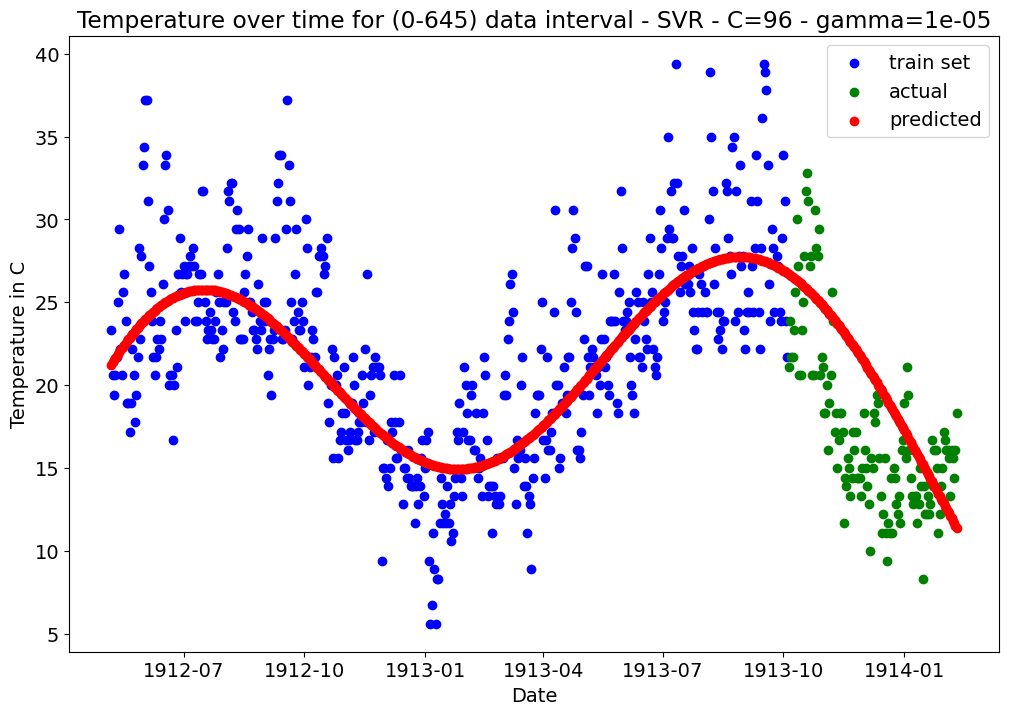

A score above 0 determined for 0-645:                    best C: 97, best gamma= 1e-05, R2 for test=0.035570039198184134


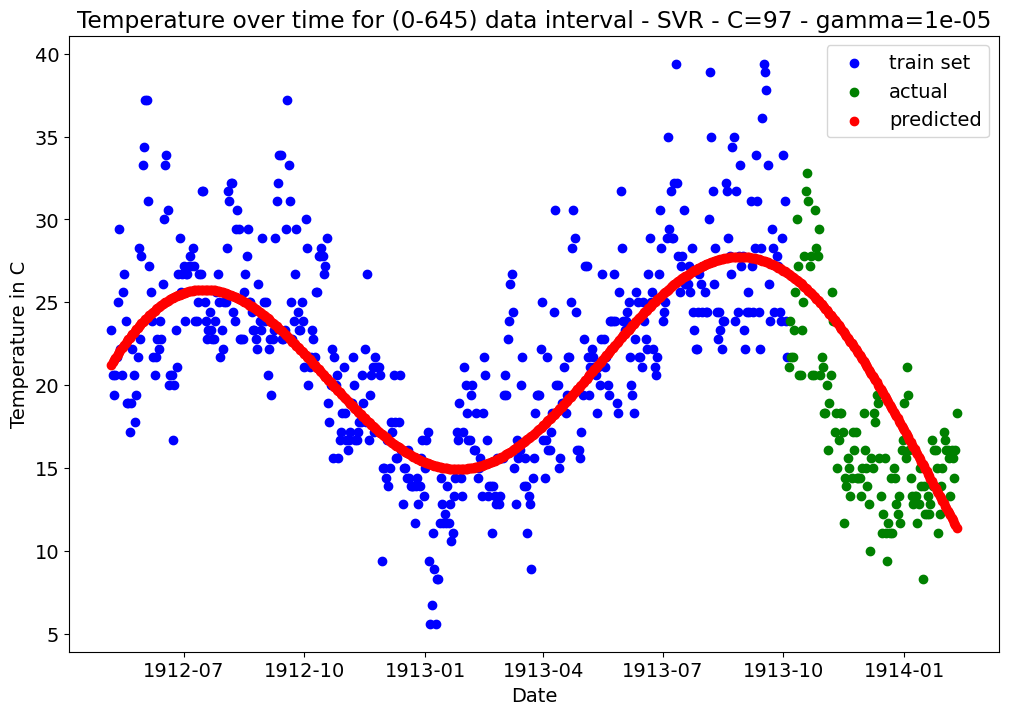

A score above 0 determined for 0-645:                    best C: 98, best gamma= 1e-05, R2 for test=0.03491827305660822


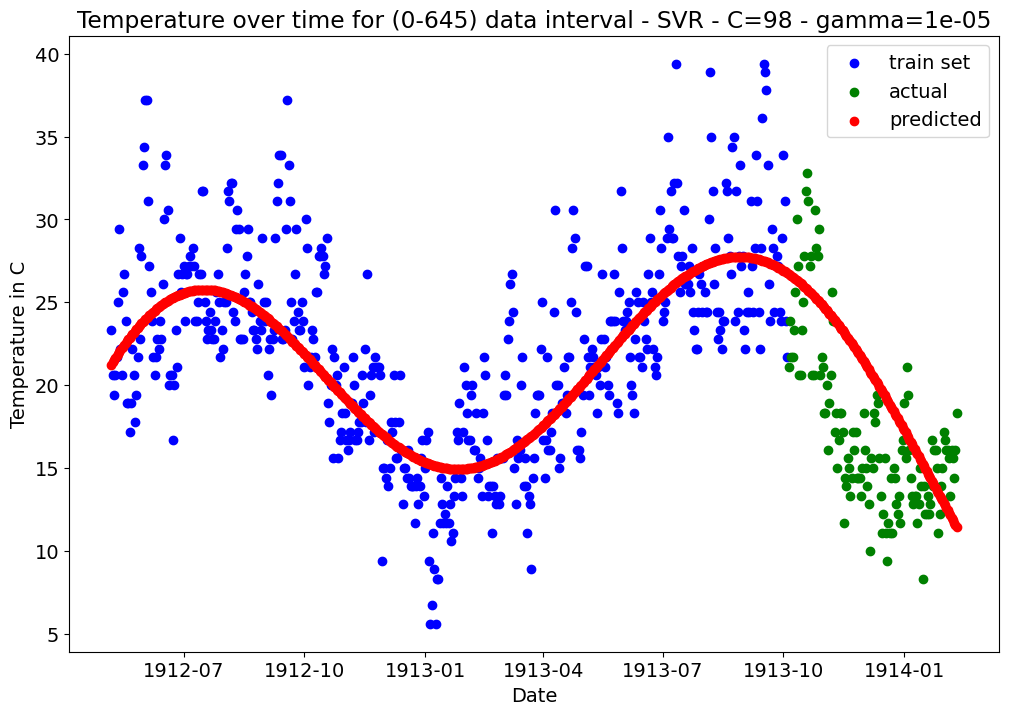

A score above 0 determined for 0-645:                    best C: 99, best gamma= 1e-05, R2 for test=0.034134484510131125


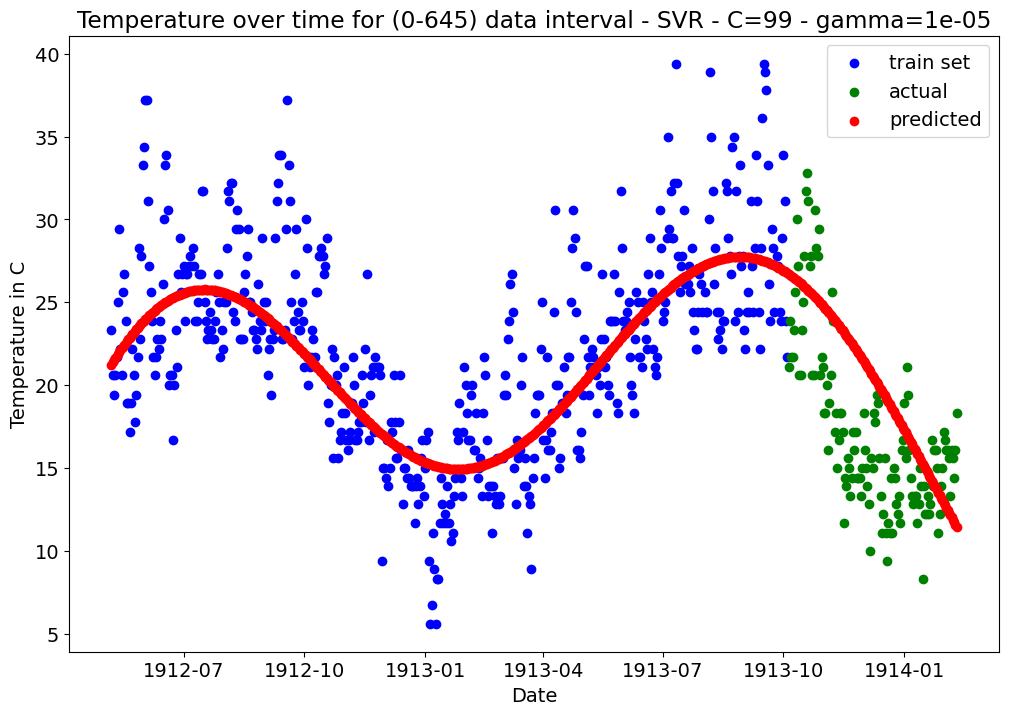

A score above 0 determined for 0-645:                    best C: 100, best gamma= 1e-05, R2 for test=0.03321040030626832


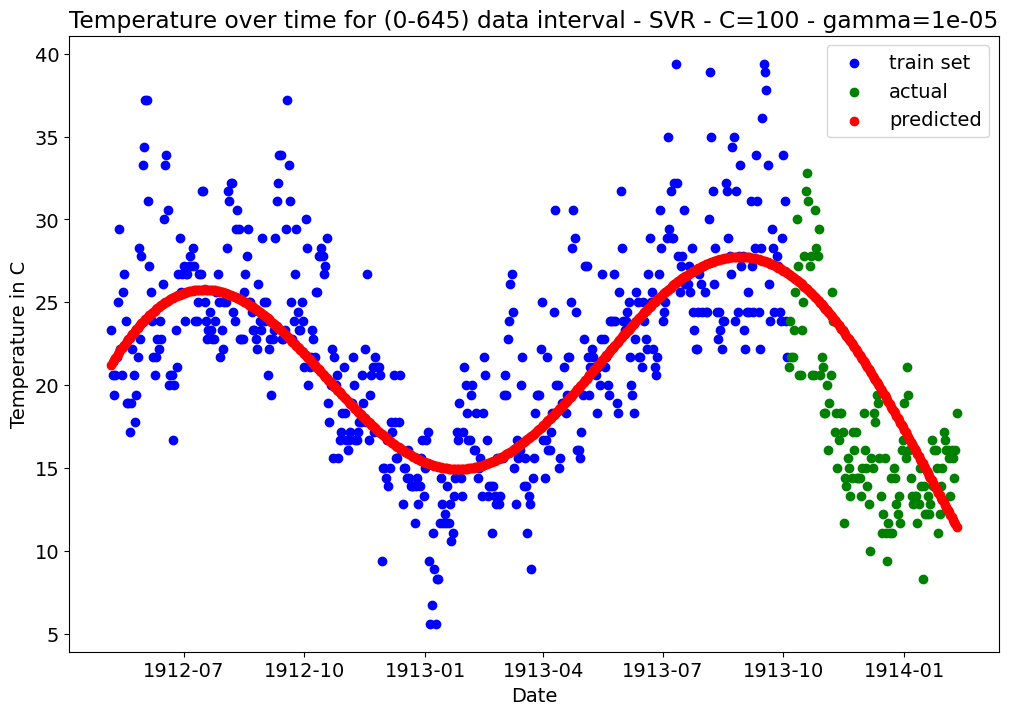

In [35]:
#From now on only acting in increments of 645 
#to adjust only for the desired chunk of data (the last 645 entries after gap)
tmax_X=np.asarray(weather_df_mid['DATE'].iloc[0:645].astype("string"))
tmax_y=np.asarray(weather_df_mid['TMAX'].iloc[0:645])

#some housekeeping
for i in range(len(tmax_X)):
    tmax_X[i]=np.datetime64(tmax_X[i])

tmax_X=tmax_X.reshape(-1, 1)

#train and test splits
tmax_X_train, tmax_X_test, tmax_y_train, tmax_y_test= train_test_split(tmax_X, tmax_y,\
                                                test_size= 0.2, shuffle=False)

#list of possible gammas (.00001, .0001 ... 10)
g=[1.e-5, 1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e-0,1.e+1]

#testing all C values from 1 to 100
for j in range(1,101):
        #picking every gamma from the list for every C
        for k in g:
            svr=SVR(kernel='rbf', C=j, gamma=k)

            svr.fit(tmax_X_train, tmax_y_train)

            svr_pred=svr.predict(tmax_X)
            
            #evaluating test set only as it is the main point of interest
            s_test=r2_score(tmax_y[-129:],svr_pred[-129:])
            
            #Only show results with the score above 0
            if s_test>0:
                print(f"A score above 0 determined for 0-645:\
                    best C: {j}, best gamma= {k}, R2 for test={s_test}")
                plt.title(f"Temperature over time for (0-645) data interval - SVR - C={j} - gamma={k}")
                plt.scatter(tmax_X_train,tmax_y_train, color="blue")
                plt.scatter(tmax_X_test, tmax_y_test,color="green")
                plt.scatter(tmax_X, svr_pred, color="red")
                plt.xlabel("Date")
                plt.ylabel("Temperature in C")
                plt.legend(['train set','actual','predicted'])
                plt.plot()
                plt.show()

*MANY MOR TESTS WERE CONDUCTED TO NARROW DOWN VALID HYPERPARAMETER VALUES*  
*FINAL FILE WAS ~75MB WHICH IS TOO BIG FOR GITHUB :(*